## CNN Feature Extraction using RestNet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import methods 
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn import linear_model, metrics, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from methods import *

## Load the Model


In [ ]:
#Using the RestNet 50 model to extract features
model = models.resnet50(pretrained = True)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval()
if torch.cuda.is_available():
    model = model.cuda()

## Data PreProcessing 

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith((".jpg", ".png"))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #Do preprocessing here 
        image_path = self.images[idx]
        rgb_image_arr = methods.convert_rgb(image_path)
        normalised_img = methods.z_normalization(rgb_image_arr)
        image = Image.fromarray(normalised_img.astype('uint8'), 'RGB')
        image_tensor = self.transform(image) if self.transform else image
        key = os.path.basename(image_path).removesuffix('.jpg').removesuffix('.png')
        return key, image_tensor

In [ ]:
original_folder_path =  '../dataverse_files/HAM10000_images_train'
lst_folders = [original_folder_path]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
data_loaders = []
for original_folder_path in lst_folders:
    dataset = ImageDataset(directory=original_folder_path, transform=transform)
    data_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)
    data_loaders.append(data_loader)

## Feature Extraction

In [ ]:
if os.path.exists('features.json'):
    features_map2 = methods.load_features('features.json').T
else:
    #Extracting features
    features_map2 = {}
    with torch.no_grad():
        for data_loader in data_loaders:
            for batch_idx, output in enumerate(data_loader):
                if torch.cuda.is_available():
                    images = images.cuda()

                
                key, images = output
                batch_features = model(images) 
                batch_features = batch_features.view(batch_features.size(0), -1)  # Flatten features
                    
                batch_features = batch_features.cpu().numpy()
                
                for i, feature in enumerate(batch_features):
                    image_id = batch_idx * data_loader.batch_size + i  # Compute global image ID/index
                    features_map2[key[i]] = feature
                    print(f'Done for image {image_id}')


## Setting up the Dataframe For Prediction

In [ ]:
labels_df = pd.read_csv('../dataverse_files/HAM10000_metadata.csv')
final_label = pd.DataFrame(labels_df['result'])
final_label.index = labels_df['image_id']
merged_data = methods.merge_features_with_labels('features.json', final_label)
merged_data.index = merged_data['image_id']
merged_data

## Prediction using Logistic regression

In [ ]:
#Get the columns that is not equal to result
X = merged_data.loc[:, ~(merged_data.columns.isin(['result', 'image_id', 'filename']))].copy()
y = merged_data['result'].copy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
model = linear_model.LogisticRegression(solver='newton-cg', multi_class='auto', max_iter=5000)
y_pred = model.fit(X_train, y_train).predict(X_test)
methods.plot_confusion_matrix(y_test,y_pred,True)

## Prediction using Linear SVM

In [ ]:
from sklearn import svm
X = merged_data.loc[:, ~(merged_data.columns.isin(['result', 'image_id', 'filename']))].copy()
y = merged_data['result'].copy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
model = svm.SVC(kernel='linear').fit(X_train, y_train)
y_pred = model.predict(X_test)
methods.plot_confusion_matrix(y_test,y_pred,True)


## Prediction Using Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes = [400]*4, 
                      random_state = 1)
X = merged_data.loc[:, ~(merged_data.columns.isin(['result', 'image_id', 'filename']))].copy()
y = merged_data['result'].copy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
methods.plot_confusion_matrix(y_test,y_pred,True)

## Prediction Using RestNet

In [ ]:
model = models.resnet50(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
    

In [ ]:
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

### Setup DataLoaders

### Define the Criterion and Scheduler


In [ ]:
 #Criterion (Loss function)
criterion = nn.CrossEntropyLoss()

# Optimizer (Only train the final layer)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
df_img_labels = pd.DataFrame(merged_data[['image_id', 'result']])
df_img_labels['result'] = df_img_labels['result'].apply(lambda x: 1 if x == 1 else 0)
df_img_labels
#0 is non-cancerous and 1 is cancerous

### Setup

In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame containing image IDs and labels.
            img_dir (str): Directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image_id = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')  # Assuming images are .jpg
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
original_folder_path =  '../dataverse_files/HAM10000_images_part_1_2'
transform =  transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = CustomImageDataset(dataframe=df_img_labels, img_dir=original_folder_path, transform=transform)

In [ ]:
from torch.utils.data import random_split
total_size = len(dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Training and Testing

Using device: mps
Epoch 1/10 - Loss: 0.3293, Acc: 0.8600
Epoch 2/10 - Loss: 0.3232, Acc: 0.8590
Epoch 3/10 - Loss: 0.3094, Acc: 0.8643
Epoch 4/10 - Loss: 0.3107, Acc: 0.8625
Epoch 5/10 - Loss: 0.3160, Acc: 0.8628
Epoch 6/10 - Loss: 0.3051, Acc: 0.8645
Epoch 7/10 - Loss: 0.3001, Acc: 0.8673
Epoch 8/10 - Loss: 0.3052, Acc: 0.8665
Epoch 9/10 - Loss: 0.3106, Acc: 0.8605
Epoch 10/10 - Loss: 0.2932, Acc: 0.8708
Accuracy: 0.846
Precision: 0.7204301075268817
Recall: 0.3435897435897436
F1 Score: 0.4652777777777778


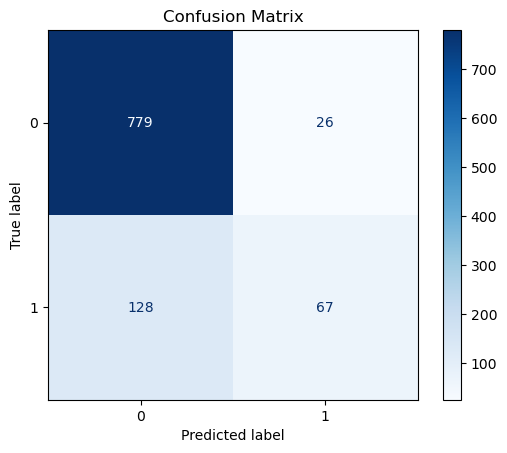

Test Loss: 0.3447, Test Acc: 0.8460


In [23]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

model.to(device)

num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_corrects = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds == labels.data)
        #print(f'Loss: {loss.item()}')

    train_loss /= len(train_loader.dataset)
    train_acc = train_corrects.float() / len(train_loader.dataset)

    # Print training results
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')

    # Evaluation loop
model.eval()  # Set model to evaluate mode
all_test_preds = []
all_test_labels = []
test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        # Statistics
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)
        
test_loss /= len(test_loader.dataset)
test_acc = test_corrects.float() / len(test_loader.dataset)

# Print test results
#Plot the confusion matrix
methods.plot_confusion_matrix(all_test_labels,all_test_preds,True)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

### Plot the Confusion Matrix

## 